In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import sklearn

%matplotlib inline

In [3]:
data = pd.read_pickle('2010-2016_alldata.pkl')
data.head()

,acting_lead,director,genre,imdb_rating,metascore,opening,opening_theatres,rating,release_date,runtime,studio,title,total_gross,total_theatres,year,num_torrents,torrent_activity
0,Ben Affleck,Zack Snyder,"Action, Adventure, Fantasy",7.2,44,166007347,4242,PG-13,2016-03-25,151 min,WB,Batman v Superman: Dawn of Justice,320495804,4256,2016,3,2
1,Ryan Reynolds,Tim Miller,"Action, Adventure, Comedy",8.3,65,132434639,3558,R,2016-02-12,108 min,Fox,Deadpool,361274848,3856,2016,0,0
2,Neel Sethi,Jon Favreau,"Adventure, Drama, Family",8.1,78,103261464,4028,PG,2016-04-15,105 min,BV,The Jungle Book,202218804,4028,2016,1,0
3,Ginnifer Goodwin,"Byron Howard, Rich Moore, Jared Bush","Animation, Action, Adventure",8.4,78,75063401,3827,PG,2016-03-04,108 min,BV,Zootopia,317554942,3959,2016,1,3
4,Jack Black,"Alessandro Carloni, Jennifer Yuh Nelson","Animation, Action, Adventure",7.4,66,41282042,3955,PG,2016-01-29,95 min,Fox,Kung Fu Panda 3,141692280,3987,2016,3,2


In [4]:
data.num_reviews = data.num_reviews + 2

AttributeError: 'DataFrame' object has no attribute 'num_reviews'

In [5]:
min_theatres = data.loc[data.opening_theatres > 500,:]

min_theatres = min_theatres[min_theatres.num_torrents < 30]
min_theatres.shape

min_theatres['month'] = min_theatres.release_date.map(lambda x: str(x.month))
min_theatres['dec_or_jun'] = min_theatres.month.map(lambda x: int(x)%6 == 0)
min_theatres['quarter'] = min_theatres.month.map(lambda x: str(int(x)//4))
min_theatres.dtypes

min_theatres = min_theatres.dropna(subset=['metascore','imdb_rating'])
min_theatres = min_theatres[min_theatres.metascore != 'N/A']
min_theatres.opening = min_theatres.opening.map(lambda x: int(x))
min_theatres.metascore = min_theatres.metascore.map(lambda x: int(x))
min_theatres.imdb_rating = min_theatres.imdb_rating.map(lambda x: float(x))
min_theatres['opening_per_theatre'] = min_theatres.opening / min_theatres.opening_theatres

min_theatres['action'] = min_theatres.genre.map(lambda x: 'action' in x)
min_theatres['comedy'] = min_theatres.genre.map(lambda x: 'comedy' in x)
min_theatres['drama']  = min_theatres.genre.map(lambda x: 'drama' in x)
min_theatres['high_metascore'] = min_theatres.metascore.map(lambda x: x >= 75)

msk = np.random.rand(len(min_theatres)) < 0.8
train = min_theatres[msk]
test  = min_theatres[~msk]

min_theatres.shape

(696, 25)

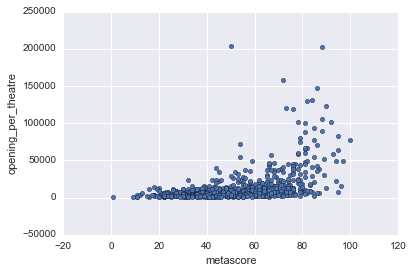

In [90]:
min_theatres.plot.scatter('metascore','opening_per_theatre')

In [7]:
import statsmodels.formula.api as sm

In [31]:
model = sm.ols('np.log(opening) ~ np.power(opening_theatres,2) + opening_theatres + high_metascore + num_torrents',data=train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(opening)   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     310.8
Date:                Sun, 01 May 2016   Prob (F-statistic):          1.97e-140
Time:                        18:56:55   Log-Likelihood:                -475.91
No. Observations:                 563   AIC:                             961.8
Df Residuals:                     558   BIC:                             983.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                        13.9043      0.182     76.435      0.000        13.547    14.262
high_metascore[T.True]            0.4644      0.107      4.336      0.000         0.254     0.675
np.power(opening_theatres, 2)    7.8e-08   2.72e-08      2.869      0.004      2.46e-08  1.31e-07
opening_theatres                  0.0006      0.000      4.573      0.000         0.000     0.001
num_torrents                      0.0109      0.005      2.041      0.042         0.000     0.021
==============================================================================
Omnibus:                        4.893   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                5.839
Skew:                           0.086   Prob(JB):                       0.0539
Kurtosis:                       3.469   Cond. No.                     7.50e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

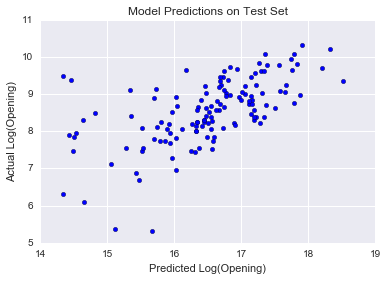

In [34]:
plt.scatter(fit.predict(test),np.log(test.opening_per_theatre))
plt.xlabel('Predicted Log(Opening)')
plt.ylabel('Actual Log(Opening)')
plt.title('Model Predictions on Test Set')

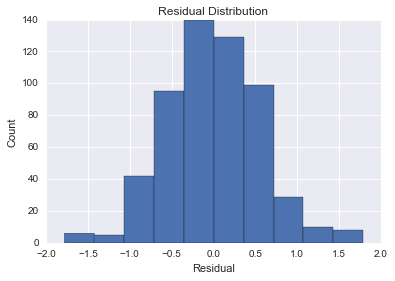

In [33]:
fit.resid.hist()
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')